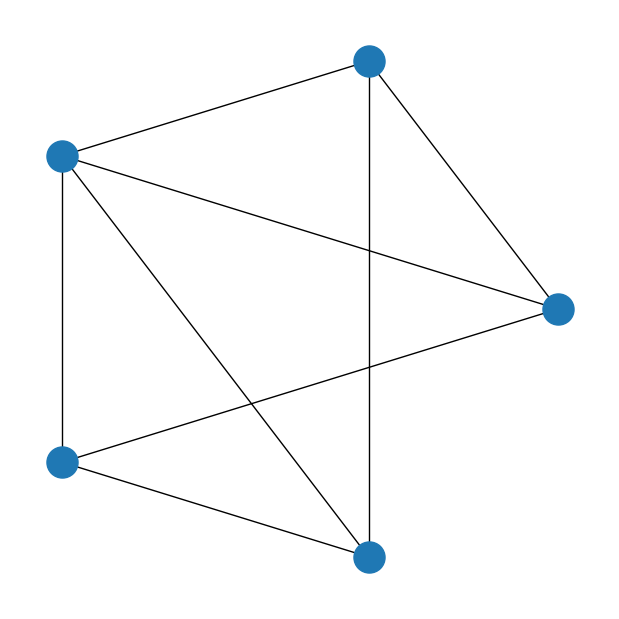

In [53]:
import numpy as np
from src.viz import simple_graph_from_adj, generate_sbm, plot_sbm, MySbmFromScratch
import networkx as nx
import torch

matrix = np.array([[0,1,1,1,0],
                  [1,0,1,0,1],
                  [1,1,0,1,1],
                  [1,0,1,0,1],
                  [0,1,1,1,0]])

simple_graph_from_adj(matrix, labels=False)

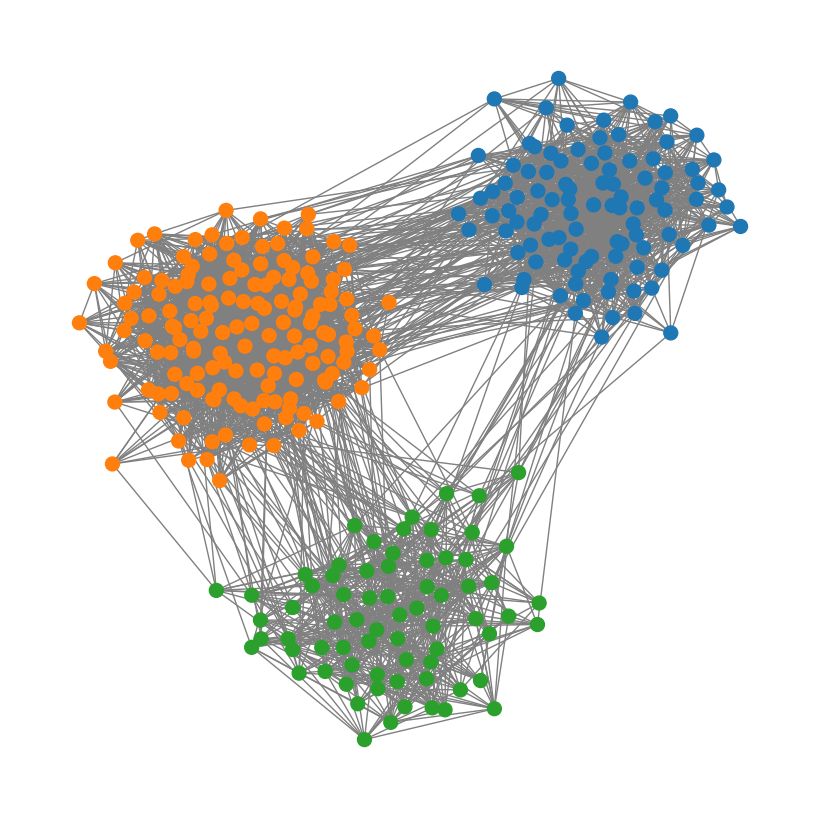

In [4]:
n_classes = [100, 150, 70]

probs = np.array([
    [0.2, 0.01, 0.005],
    [0.01, 0.15, 0.009],
    [0.005, 0.009, 0.2]
])

G = generate_sbm(n_classes, probs)

plot_sbm(G, n_classes)


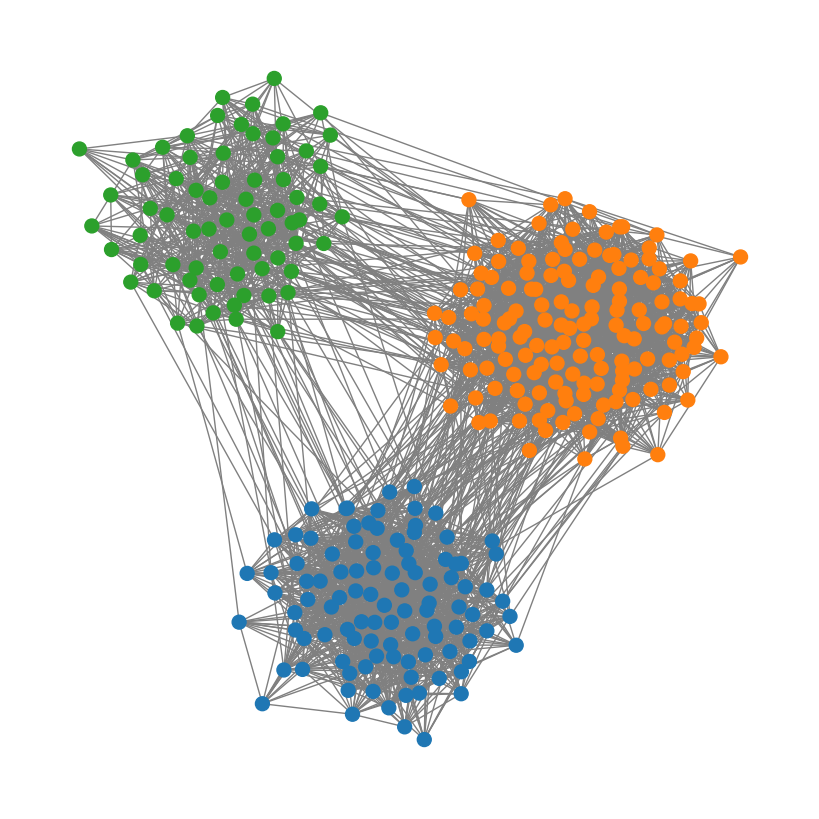

In [5]:
sbm = MySbmFromScratch()

sbm.generate_graph(n_classes = n_classes, probs = probs)
sbm.plot_graph()


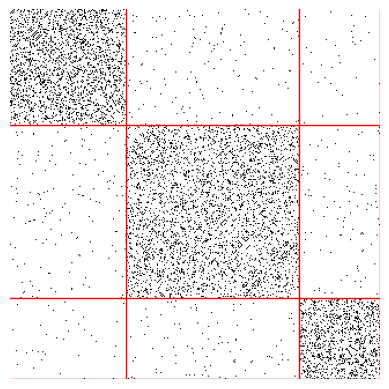

In [6]:
sbm.plot_adj()

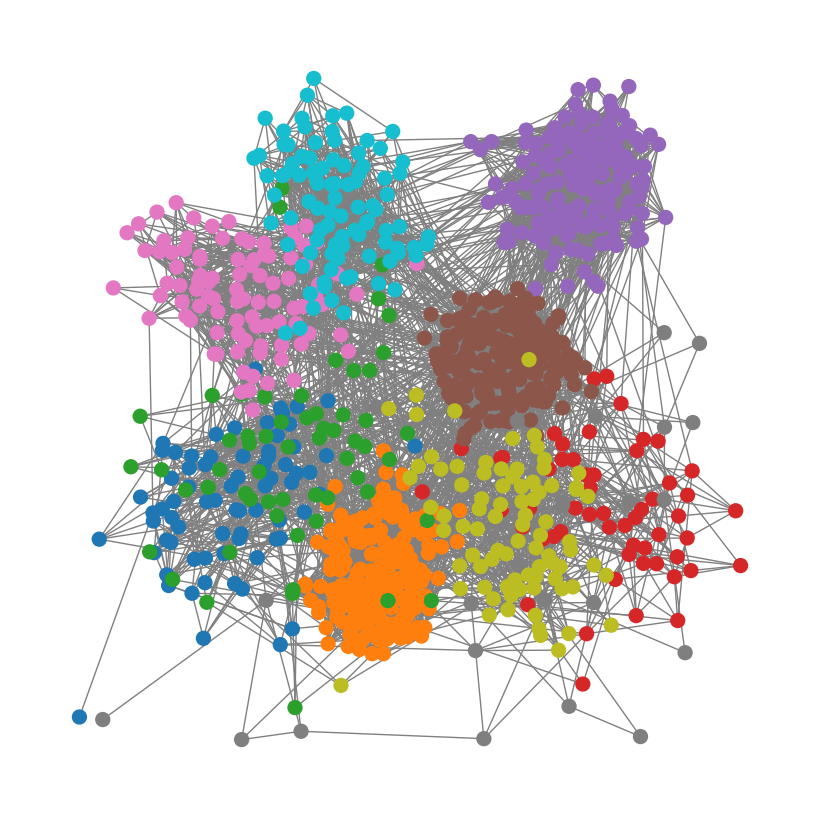

In [18]:
sbm = MySbmFromScratch()

sbm.generate_graph(N = 1000, K=10, _lambda=0.1, multiplier=0.2, alpha=1.5)
sbm.plot_graph()


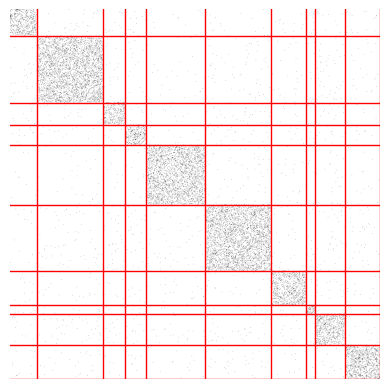

In [19]:
sbm.plot_adj()

In [60]:
class MixtureModel():
    def __init__(self, X, n, k):
        self.N = n
        self.K = k
        self.X = torch.tensor(X, dtype=torch.float)

        tau = torch.rand(n, k)
        tau /= tau.sum(dim=1, keepdim=True)
        self.tau = tau

    def comp_alpha_pi(self):
        mask = ~torch.eye(self.N, dtype=bool)

        numerator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, self.X * mask)

        denominator = torch.einsum('iq,jl,ij->lq', self.tau, self.tau, mask.float())

        pi = numerator / denominator

        alpha = self.tau.mean(dim=0)   

        return alpha, pi  # (K), (KxK)
    
    def compute_tau(self, alpha, pi, tau):

        N, K = tau.size()

        X_expanded = self.X.unsqueeze(-1).unsqueeze(-1)  #  (N, N, 1, 1)
        pi_expanded = pi.unsqueeze(0).unsqueeze(0)  # (1, 1, K, K)

        b_term = pi_expanded ** X_expanded * (1 - pi_expanded) ** (1 - X_expanded)

        tau_expanded = tau.unsqueeze(0).unsqueeze(-1)  # (1, N, K, 1)
        b_tau = b_term ** tau_expanded

        mask = torch.eye(N, device=self.X.device).unsqueeze(-1).unsqueeze(-1)  # (N, N, 1, 1)
        masked_b_tau = b_tau * (1 - mask)

        prod_jl = torch.einsum('ijnq->iq', masked_b_tau)

        alpha_expanded = alpha.unsqueeze(0).expand(N, K)  # (N, K)

        res = alpha_expanded * prod_jl

        res_sum = res.sum(dim=1, keepdim=True)

        return res/res_sum # [NxK]


test = MixtureModel(sbm.adj, sbm.adj.shape[0], 3)
alpha, pi = test.comp_alpha_pi()
tau = test.compute_tau(alpha, pi, test.tau)
print(tau.shape)


torch.Size([994, 3])


In [61]:
tau.sum(dim=1)[:5]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])